In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from loguru import logger
import seaborn as sns

In [4]:
import os
import sys
sys.path.append('..')

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.evaluation import run_experiment, _select_significant_entries, _compute_prec_rec_f1
from pals.common import save_obj, set_log_level_debug, set_log_level_info, set_log_level_warning, DATABASE_PIMP_KEGG, SIGNIFICANT_THRESHOLD
from pals.feature_extraction import DataSource
from pals.PALS import PALS
from pals.ORA import ORA

2020-01-06 13:26:02.757 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-01-06 13:26:02.757 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-01-06 13:26:03.831 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


# HAT Data Analysis

This notebook is used to generate resampled data and run the different methods for comparison in the manuscript.

### Load data

Assume token is stored in environmental variable *PIMP_API_TOKEN*

In [6]:
token = get_pimp_API_token_from_env()

In [7]:
analysis_id_plasma = 636
int_df_plasma, annotation_df_plasma, experimental_design_plasma = download_from_pimp(token, PIMP_HOST, analysis_id_plasma, 'kegg')

2020-01-06 13:26:03.981 | DEBUG    | pals.pimp_tools:download_from_pimp:119 - Trying to load data from temp file: C:\Users\joewa\AppData\Local\Temp\pimp_analysis_636.p
2020-01-06 13:26:03.982 | WARNING  | pals.common:load_obj:94 - Old, invalid or missing pickle in C:\Users\joewa\AppData\Local\Temp\pimp_analysis_636.p. Please regenerate this file.
2020-01-06 13:26:03.983 | DEBUG    | pals.pimp_tools:download_from_pimp:123 - Retrieving data for analysis 636 from PiMP
2020-01-06 13:26:13.165 | DEBUG    | pals.pimp_tools:get_data:33 - http://polyomics.mvls.gla.ac.uk/export/get_ms1_intensities?analysis_id=636
2020-01-06 13:26:32.299 | DEBUG    | pals.pimp_tools:get_data:33 - http://polyomics.mvls.gla.ac.uk/export/get_ms1_peaks?analysis_id=636
2020-01-06 13:26:48.910 | DEBUG    | pals.pimp_tools:get_data:33 - http://polyomics.mvls.gla.ac.uk/export/get_experimental_design?analysis_id=636
2020-01-06 13:26:48.911 | DEBUG    | pals.pimp_tools:download_from_pimp:132 - Caching analysis data for ne

### Create Data Sources

In [8]:
database_name = DATABASE_PIMP_KEGG
ds_plasma = DataSource(int_df_plasma, annotation_df_plasma, experimental_design_plasma, database_name)

2020-01-06 13:26:54.169 | DEBUG    | pals.feature_extraction:__init__:42 - Using PiMP_KEGG as database
2020-01-06 13:26:54.169 | DEBUG    | pals.feature_extraction:get_database:105 - Loading C:\Users\joewa\Work\git\PALS\pals\data\PiMP_KEGG.json.zip
2020-01-06 13:26:54.190 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-01-06 13:26:54.196 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-01-06 13:26:54.586 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


### Grid search over PALS plage and hg parameters

In this section, we compare the difference in pathway ranking due to varying the PLAGE and Hypergeometric parameters.

plage=1 and hg=1 is set as the reference, and other results (with different plage and hg values) are evaluated w.r.t to that.

In [9]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weights = range(1, 11)
pals_hg_weights = range(1, 11)
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
N = None
threshold = SIGNIFICANT_THRESHOLD

In [10]:
set_log_level_info() # don't print too many debug messages during experiment

In [11]:
results = {}
for pals_plage_weight in pals_plage_weights:
    for pals_hg_weight in pals_hg_weights:
        logger.info('Running PALS with plage_weight=%d hg_weight=%d' % (pals_plage_weight, pals_hg_weight))
        
        # run PALS and select the top-N significant pathways from the results
        pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
        full_df_pals = pals.get_pathway_df(resample=pals_resample)
        full_df_pals.sort_values(significant_column, inplace=True)
        pals_full = _select_significant_entries(full_df_pals, significant_column, threshold, N)
        
        # store the results for analysis later
        key = (pals_plage_weight, pals_hg_weight, )
        results[key] = pals_full

2020-01-06 13:26:54.813 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=1
2020-01-06 13:27:00.652 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=2
2020-01-06 13:27:06.674 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=3
2020-01-06 13:27:12.410 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=4
2020-01-06 13:27:18.113 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=5
2020-01-06 13:27:23.823 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=6
2020-01-06 13:27:29.517 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=7
2020-01-06 13:27:35.258 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=8
2020-01-06 13:27:41.005 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=9
2020-01-06 13:27:46.732 | INFO     | __main__:<module>:4 - Runni

In [12]:
set_log_level_debug()

Computes Jacard Index between two sets, and uses this as a similarity score in different pathway ranking results.

In [13]:
def jacard_index(s1, s2):
    return float(len(s1.intersection(s2))) / float(len(s1.union(s2)))

In [14]:
pals_plage_weights = np.array(range(1, 11))
pals_hg_weights = np.array(range(1, 11))

reference = (1, 1)
sim_mat = np.zeros((len(pals_plage_weights), len(pals_hg_weights)))

for i in range(len(pals_plage_weights)):
    pals_plage_weight = pals_plage_weights[i]
    
    for j in range(len(pals_hg_weights)):
        pals_hg_weight = pals_hg_weights[j]
        to_check = (pals_plage_weight, pals_hg_weight, )
        s1 = set(results[reference].index.values)
        s2 = set(results[to_check].index.values)
        sim = jacard_index(s1, s2)        
        sim_mat[i, j] = sim

Make a plot of similarity

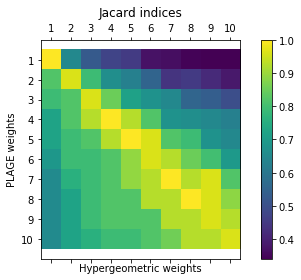

In [15]:
fig, ax = plt.subplots(1, 1)
img = ax.matshow(sim_mat)
ax.set_xticks(pals_hg_weights-1)
ax.set_xticklabels(pals_hg_weights)
ax.set_xlabel('Hypergeometric weights')
ax.set_yticks(pals_plage_weights-1)
ax.set_yticklabels(pals_plage_weights)
ax.set_ylabel('PLAGE weights')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.colorbar(img)
plt.title('Jacard indices', y=1.08)
plt.tight_layout()

plt.savefig(os.path.join('test_data', 'HAT', 'similarity.eps'), dpi=300)

### Compare ORA vs PALS

#### PLAGE weight = 5, hg weight = 1

In [16]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weight = 5
pals_hg_weight = 1
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
case = 'Stage1'
control = 'Control'
N = 20
threshold = SIGNIFICANT_THRESHOLD

Run PALS and ORA on the full data

In [17]:
pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
pals_df = pals.get_pathway_df(resample=pals_resample)
pals_df.sort_values(significant_column, inplace=True)

2020-01-06 13:37:23.186 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:280 - Setting the zero intensity values in the dataframe
2020-01-06 13:37:23.263 | DEBUG    | pals.feature_extraction:standardize_intensity_df:261 - Scaling the data across the sample: zero mean and unit variance
2020-01-06 13:37:23.326 | DEBUG    | pals.PALS:get_plage_activity_df:76 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2020-01-06 13:37:23.326 | DEBUG    | pals.PALS:get_plage_activity_df:77 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-01-06 13:37:25.462 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:88 - Calculating plage p-values with resampling
2020-01-06 13:37:25.463 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:92 - Comparison Stage2/Stage1
2020-01-06 13:37:25.464 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:100 - Resampling 0/1000
2020-01-06 13:37:25.566 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:100 - Resampling 100/1000
2020-01

In [18]:
_select_significant_entries(pals_df, significant_column, threshold, None)

,pw_name,p_value,sf,unq_pw_F,tot_ds_F,F_coverage
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000e+00,4.359032e-01,5,1,20.00
map04961,Endocrine and other factor-regulated calcium r...,0.000000e+00,5.514965e-01,7,1,14.29
map00903,Limonene and pinene degradation,2.527999e-20,2.960171e-02,17,5,29.41
map00902,Monoterpenoid biosynthesis,1.252553e-11,4.650501e-02,19,5,26.32
map00930,Caprolactam degradation,2.096469e-11,5.218894e-08,19,12,63.16
map00622,Xylene degradation,8.430908e-11,9.271170e-05,24,10,41.67
map00626,Naphthalene degradation,5.233412e-09,5.036634e-01,43,5,11.63
map00981,Insect hormone biosynthesis,1.578742e-08,4.002601e-01,21,3,14.29
map05215,Prostate cancer,4.430128e-08,2.532519e-01,9,2,22.22
map00623,Toluene degradation,5.389000e-08,4.102787e-01,30,4,13.33


#### PLAGE weight = 1, hg weight = 5

In [19]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weight = 1
pals_hg_weight = 5
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
case = 'Stage1'
control = 'Control'
N = 20
threshold = SIGNIFICANT_THRESHOLD

In [20]:
pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
pals_df = pals.get_pathway_df(resample=pals_resample)
pals_df.sort_values(significant_column, inplace=True)

2020-01-06 13:37:29.506 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:280 - Setting the zero intensity values in the dataframe
2020-01-06 13:37:29.585 | DEBUG    | pals.feature_extraction:standardize_intensity_df:261 - Scaling the data across the sample: zero mean and unit variance
2020-01-06 13:37:29.639 | DEBUG    | pals.PALS:get_plage_activity_df:76 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2020-01-06 13:37:29.640 | DEBUG    | pals.PALS:get_plage_activity_df:77 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-01-06 13:37:31.798 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:88 - Calculating plage p-values with resampling
2020-01-06 13:37:31.799 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:92 - Comparison Stage2/Stage1
2020-01-06 13:37:31.799 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:100 - Resampling 0/1000
2020-01-06 13:37:31.905 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:100 - Resampling 100/1000
2020-01

In [21]:
_select_significant_entries(pals_df, significant_column, threshold, None)

,pw_name,p_value,sf,unq_pw_F,tot_ds_F,F_coverage
map04961,Endocrine and other factor-regulated calcium r...,0.000000e+00,5.514965e-01,7,1,14.29
map00903,Limonene and pinene degradation,0.000000e+00,2.960171e-02,17,5,29.41
map00623,Toluene degradation,0.000000e+00,4.102787e-01,30,4,13.33
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000e+00,4.359032e-01,5,1,20.00
map00626,Naphthalene degradation,0.000000e+00,5.036634e-01,43,5,11.63
map00622,Xylene degradation,0.000000e+00,9.271170e-05,24,10,41.67
map00330,Arginine and proline metabolism,1.516115e-11,7.407819e-14,79,34,43.04
map00930,Caprolactam degradation,9.049377e-11,5.218894e-08,19,12,63.16
map00260,"Glycine, serine and threonine metabolism",1.776740e-06,8.567758e-10,41,20,48.78
map00250,"Alanine, aspartate and glutamate metabolism",8.754384e-06,8.123660e-06,23,11,47.83
